In [1]:
#!pip install synapseclient

In [2]:
#!pip install synapseutils

In [3]:
#  import synapseclient 
#  import synapseutils 
 
#  syn = synapseclient.Synapse() 
#  syn.login('finamintoastcrunch','1Hjldria!') 
#  files = synapseutils.syncFromSynapse(syn, ' syn2825306 ') 

In [4]:
# !pip install -q tensorflow-model-optimization

# Import Libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import*
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import MinMaxScaler

In [6]:
df = pd.DataFrame

In [7]:
tf.config.list_physical_devices(
    device_type=None
)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.executing_eagerly()

True

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [11]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
NUM_PARENTS = 41
NUM_TARGETS = 100
NUM_TIME_STEPS = 21
NUM_REPLICATES = 10 

In [13]:

# matrix_path = "regulator-gene-matrix.csv"
# data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
# data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
# data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
# data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"
# data_path_petal = r"C:\Users\Fin Amin\Desktop\StemCellResearch\petal_len.xlsx"

In [14]:
# dirty_RGM = r'Regulations_Control_Altona.csv'
dirty_regulations = r'insilico_size100_1_timeseries.csv'

In [15]:
dirtyReg = pd.read_csv(dirty_regulations,  index_col = 0,)# on_bad_lines='skip')
dirtyReg = dirtyReg.dropna(axis=0)
dirtyReg = dirtyReg.select_dtypes(include=np.number)
dirtyReg = dirtyReg.to_numpy() #reshape would not work in this case. 

dRegs = np.zeros(shape=(NUM_REPLICATES, NUM_TIME_STEPS, NUM_TARGETS), dtype=np.float)
for i in range(NUM_REPLICATES):
    dRegs[i] = dirtyReg[NUM_TIME_STEPS*i : NUM_TIME_STEPS*(i+1)]
dRegs.shape

(10, 21, 100)

In [16]:

def fix_dataset(dirtyR):
    ds = dirtyR
    ret = np.zeros(shape=(NUM_REPLICATES,NUM_TIME_STEPS, NUM_TARGETS))

    # for i in range(0,NUM_REPLICATES*NUM_TIME_STEPS, 4):
    #     for j in range(0, NUM_REPLICATES):
    #         dataset[j][:,i//NUM_REPLICATES] = dirtyR[:,(i+j)]
    
    ds[ds==0.0] = np.nan #we do this so the scaling ignores 0.0 #CHECKED


    for i in range(NUM_REPLICATES):
        regScaled = StandardScaler().fit_transform(ds[i].flatten().reshape((-1,1)))
        regScaled = MinMaxScaler().fit_transform(ds[i].flatten().reshape((-1,1))) #ignores np.nan
        regScaled = regScaled.reshape((NUM_TARGETS, NUM_TIME_STEPS))
        regScaled = np.nan_to_num(regScaled, nan= 0.0)
        ret[i] = regScaled.T
    return ret

dataset = fix_dataset(dirtyR=dRegs)
dataset.shape

(10, 21, 100)

In [17]:
dataset[0]

array([[0.15300698, 0.17242697, 0.79758853, ..., 0.08191029, 0.12975706,
        0.03934641],
       [0.27451402, 0.22530717, 0.61496231, ..., 0.07429333, 0.2986516 ,
        0.67589515],
       [0.70780315, 0.16051352, 0.909139  , ..., 0.97443771, 0.01375137,
        0.16942395],
       ...,
       [0.09252425, 0.74741258, 0.01219214, ..., 0.45413509, 0.03334866,
        0.75625035],
       [0.00253184, 0.09286092, 0.39454038, ..., 0.40550657, 0.12740767,
        0.63230157],
       [0.06762939, 0.72373928, 0.69529719, ..., 0.28241947, 0.1940238 ,
        0.72104984]])

In [18]:
beanIntensities = dataset[0:8]
validation = dataset[8:]
allData = dataset
print(beanIntensities.shape, validation.shape, allData.shape)

(8, 21, 100) (2, 21, 100) (10, 21, 100)


In [19]:
#the third replicate is trash. we will not use it. 
# df(dataset[3]).head(11) 

In [20]:
# regulator_gene_matrix = np.load("soyBeanRGM.npy")
# regulator_gene_matrix = regulator_gene_matrix.astype('float32')
# regulator_gene_matrix.shape

# Load and Compare Gold Standard

In [21]:
gold = pd.read_csv("DREAM4_GoldStandard_InSilico_Size100_1.csv", header=None)
gold.head(5)


,0,1,2
0,G1,G2,1
1,G1,G3,1
2,G1,G4,1
3,G5,G2,1
4,G5,G3,1


In [23]:
def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )
gold = keep_numeric(gold)
goldnp = np.array(gold, dtype = 'int')
#subtract 1 from each index to match python index
goldnp[:,0] = goldnp[:,0] - 1
goldnp[:,1] = goldnp[:,1] - 1

goldIm = np.zeros(shape=(NUM_TARGETS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection



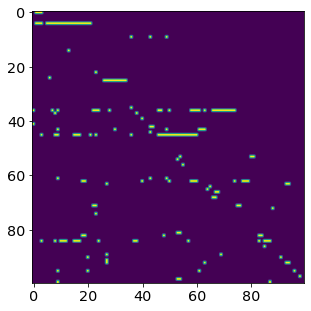

In [24]:
plt.imshow(goldIm)

In [25]:
non_zero = np.nonzero(goldIm) #non-zero hold all the true connections
#non_zero = np.array(np.unravel_index(non_zero, shape = (NUM_PARENTS, NUM_TARGETS)))

# RGM and RGM+

In [26]:
regulator_gene_matrix = goldIm.astype(np.float32) #I set rgm to gold because I didnt not want ot re-write everything
superParent = regulator_gene_matrix.copy()
ones = np.ones((NUM_TARGETS))
parentIndex = []
not_parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
    else:
        not_parentIndex.append(i)

parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)
parent_idx = parentIndex.numpy()
not_parentIndex = np.array(not_parentIndex)
not_parentIndex = tf.convert_to_tensor(not_parentIndex)
print("shape of parent index", parentIndex.shape)




#the code below runs the experiment without any known regulators
regulator_gene_matrix = np.ones((NUM_TARGETS,NUM_TARGETS), dtype='float32') #we keep this because we want to not mess with the weight init
# superParent = np.ones((NUM_TARGETS, NUM_TARGETS), dtype = 'float32')
# parentIndex = np.arange(stop=NUM_PARENTS)
# parentIndex = tf.convert_to_tensor(parentIndex)
# parent_idx = parentIndex.numpy()

shape of parent index (41,)


In [27]:
parentIndex

<tf.Tensor: shape=(41,), dtype=int32, numpy=
array([ 0,  4,  9, 14, 22, 24, 25, 35, 36, 37, 39, 41, 42, 43, 44, 45, 53,
       54, 56, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 81, 82, 84, 86, 89,
       90, 91, 92, 95, 97, 98, 99])>

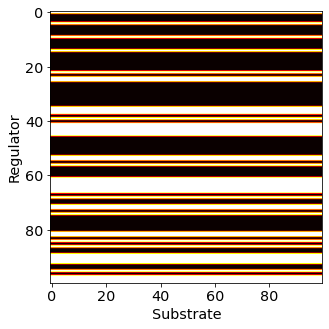

In [28]:
plt.imshow(superParent, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

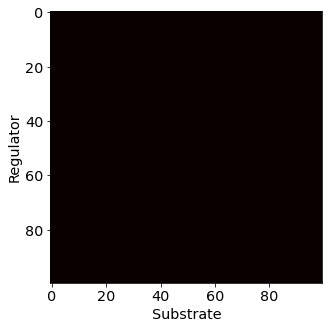

In [29]:
plt.imshow(regulator_gene_matrix, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

# Custom Loss

In [30]:
# superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
# #print(superParent.shape)

# ones = np.ones((NUM_TARGETS))
# parentIndex = []
# not_parentIndex = []
# for i in range(len(regulator_gene_matrix)):
#     if (np.isin(regulator_gene_matrix[i], [1])).any():
#         #print(i)
#         superParent[i] = ones 
#         parentIndex.append(i)
#     else:
#         not_parentIndex.append(i)

# parentIndex = np.array(parentIndex)
# parentIndex = tf.convert_to_tensor(parentIndex)
# parent_idx = parentIndex.numpy()
# not_parentIndex = np.array(not_parentIndex)
# not_parentIndex = tf.convert_to_tensor(not_parentIndex)
# print("shape of parent index", parentIndex.shape)

def ignore_noParent_MSE_old(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2) 
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

#this will not work if the entire dataset is -1 (degenerate), or has only one actual value (also degen)
def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
   # print(y_true.shape) #(None, 44, 372)

    #get the parents and flatten them
    y_true_pruned = tf.gather(y_true, parentIndex, axis = 2) #axis 2 because batch, time, gene
    y_true_pruned = tf.reshape(y_true_pruned, shape=([tf.size(y_true_pruned)] ) )

   # print(y_true_pruned.shape)
   # print("tf size", tf.size(y_true_pruned))

    y_pred_pruned = tf.gather(y_pred, parentIndex, axis = 2) 
    y_pred_pruned = tf.reshape(y_pred_pruned, shape=([tf.size(y_pred_pruned)]) )

    #get the index of the parents which are not -1
    y_true_posID = tf.where(y_true_pruned >= 0) #gets args
    y_true_posID = tf.squeeze(y_true_posID)
    #get the idx of all the -1s 
    y_true_negID = tf.where(y_true_pruned < 0) 
    y_true_negID = tf.squeeze(y_true_negID)

    #get all the -1s in the parents 
    y_true_neg = tf.gather(y_true_pruned, y_true_negID) #get all the -1s in y_true
    y_pred_neg = tf.gather(y_pred_pruned, y_true_negID) #get the corresponding values for y_pred

    #get the indexes where pred should be -1 but is not. get the corresponding index for ytrue
    y_shouldBeNegButIsntID = tf.where(y_pred_neg >= 0)  
    y_shouldBeNegButIsntID = tf.squeeze(y_shouldBeNegButIsntID) #get the idx which should be -1 for prediction but are not
    y_true_wrong = tf.gather(y_true_pruned, y_shouldBeNegButIsntID) #get the same corresponding values from ytrue
    y_shouldBeNegButIsnt = tf.gather(y_pred_pruned, y_shouldBeNegButIsntID) #this has all the wrongly predicted values which should be -1 but are not

    y_true_pos = tf.gather(y_true_pruned, y_true_posID)
    y_pred_pos = tf.gather(y_pred_pruned, y_true_posID)

    if tf.size(y_shouldBeNegButIsnt) == 0: #we can not concatenate if the size is 0. 
        return l(y_true_pos, y_pred_pos)

    if tf.size(y_shouldBeNegButIsnt) == 1: #dim goes away if size = 1. 
        y_shouldBeNegButIsnt = tf.expand_dims(y_shouldBeNegButIsnt, axis = 0) #should all be flattened
        y_true_wrong = tf.expand_dims(y_true_wrong, axis=0)

    #print("y_pred", (y_pred_pos), "y_true", (y_shouldBeNegButIsnt))
    try:
        y_pred_total = tf.concat([y_pred_pos, y_shouldBeNegButIsnt], axis = 0) #concatenate for total mse
        y_true_total = tf.concat([y_true_pos, y_true_wrong], axis = 0)
    except Exception as e:
        print(y_pred_pos.shape, y_shouldBeNegButIsnt.shape, tf.size(y_shouldBeNegButIsnt))
        return l(y_true_pos, y_pred_pos)

    return l(y_true_total, y_pred_total)

In [31]:
parent_idx

array([ 0,  4,  9, 14, 22, 24, 25, 35, 36, 37, 39, 41, 42, 43, 44, 45, 53,
       54, 56, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 81, 82, 84, 86, 89,
       90, 91, 92, 95, 97, 98, 99])

# Ordinary Auto Encoder

In [32]:
# class EncoderLinear(tf.keras.layers.Layer):
#     def __init__(self, rgm, input_dim=32, units=32):
#         super(EncoderLinear, self).__init__()
#         self.rgm = rgm
        
#         def init_weights(shape, dtype="float32"):

#             w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

#             return w_init
        

#         self.w = tf.Variable(
#             initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
#             trainable=True,
#         )

#     def call(self, inputs):
#         X = inputs
#         return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [33]:
# class DecoderLinear(tf.keras.layers.Layer):
#     def __init__(self, rgm, input_dim=32, units=32):
#         super(DecoderLinear, self).__init__()
#         self.rgm = rgm

#         def init_weights(shape, dtype="float32"):

#             w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

#             return w_init
    
        
#         self.w = tf.Variable(
#             initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
#             trainable=True,
#         )

#     def call(self, inputs):
#         X = inputs
#         #return tf.matmul(X, tf.multiply((self.rgm), self.w))
#         X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
#         #return tf.matmul(inputs, self.w)
#         # v = tf.zeros_like(X)
#         # u = tf.ones_like(X)
#         # u = tf.math.scalar_mul(-3.0, u)
        
#         return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [34]:
# def encoder(parent_child_biological_association, num_hidden_units=21):
#     '''
#     Encoder structure
#     '''
#     '''
#     The data is time-series. Therefore, CNN to learn the temporal relationship between 
#     the intensities for each gene.
#     '''
#     en_conv = Conv1D(490, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS Conv1D(32, 3, activation = "relu")(parent_child_biological_association)
#     en_dense = Flatten()(en_conv)
#     phenotype = Dense(num_hidden_units)(en_dense)
#     return phenotype

# def decoder(X, num_protein_gene, time_steps):
#     '''
#     Decoder structure
#     '''
#     de_dense = Dense(1024)(X)#Dense(128)(X)
#     de_dense = Reshape((1, 1024))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
#     de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
#     #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
#     # gene_reconstruction = self.decoder_biological_operation(de_deconv)
#     return de_deconv

# def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 32):
#     inp = Input(shape=(time_steps, num_kinase_regulators))
#     x = EncoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(inp)
#     enc = encoder(x, num_hidden_units)
#     dec = decoder(enc, num_protein_gene, time_steps)
#     out = DecoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(dec)

#     _model = tf.keras.Model(inputs=inp, outputs=out)

#     return _model

In [35]:
# ordinaryAE = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS)
# ordinaryAE.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [36]:
# o = ordinaryAE.fit(beanIntensities, beanIntensities, epochs=200, verbose = True, validation_data=(validation, validation))
#print(o.history['loss'][-1]) #the final loss 

# Super Parent AutoEncoder

In [37]:
class EncoderLinearSuperParent(tf.keras.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm


        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def get_prunable_weights(self):
        # Prune bias also, though that usually harms model accuracy too much.
        return [self.w]

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    rnn = LSTM(units = num_hidden_units)(parent_child_biological_association)
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21, sparsity = 0.0): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = tfmot.sparsity.keras.prune_low_magnitude(EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS),
                                                 pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(sparsity, 0))(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [38]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [39]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = True,  
                    validation_data=(validation, validation), callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(o.history['loss'][-1]) #the final loss 

Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 0.2206 - val_loss: 0.1996
Epoch 2/200
1/1 [==============================] - 0s 27ms/step - loss: 0.2157 - val_loss: 0.1911
Epoch 3/200
1/1 [==============================] - 0s 25ms/step - loss: 0.2060 - val_loss: 0.1760
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 0.1890 - val_loss: 0.1532
Epoch 5/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1633 - val_loss: 0.1231
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 0.1295 - val_loss: 0.0937
Epoch 7/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0965 - val_loss: 0.0869
Epoch 8/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0885 - val_loss: 0.0943
Epoch 9/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0964 - val_loss: 0.0771
Epoch 10/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0773 - val_loss: 0.0579
Epoch 11/200
1/1 [===

In [40]:
looseParent.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 100)]         0         
                                                                 
 prune_low_magnitude_encoder  (None, 21, 100)          20002     
 _linear_super_parent (Prune                                     
 LowMagnitude)                                                   
                                                                 
 conv1d (Conv1D)             (None, 19, 32)            9632      
                                                                 
 flatten (Flatten)           (None, 608)               0         
                                                                 
 dense (Dense)               (None, 32)                19488     
                                                                 
 dense_1 (Dense)             (None, 128)               4224  

# DenseNetAutoEncoder

In [41]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''

class DAE_Encoder_MASK(tf.keras.layers.Layer): 
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DAE_Encoder_MASK, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })

class DAE_Decoder_MASK(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DAE_Decoder_MASK, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose


    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(NUM_TARGETS, 7, activation = "tanh")(parent_child_biological_association) # Conv1D(NUM_TARGETS, NUM_TIME_STEPS, activation = "tanh")(parent_child_biological_association)6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    d = Concatenate()([en_dense, inp]) #dense layer
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(NUM_TARGETS, activation = 'tanh')(X)
    de_dense = Reshape((1, NUM_TARGETS))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = DAE_Encoder_MASK(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DAE_Decoder_MASK(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [42]:
dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
dense.fit(beanIntensities, beanIntensities, epochs=150,  verbose=True, validation_data=(validation, validation))

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.2221 - val_loss: 0.2023
Epoch 2/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2195 - val_loss: 0.1803
Epoch 3/150
1/1 [==============================] - 0s 35ms/step - loss: 0.1951 - val_loss: 0.1603
Epoch 4/150
1/1 [==============================] - 0s 31ms/step - loss: 0.1727 - val_loss: 0.1398
Epoch 5/150
1/1 [==============================] - 0s 38ms/step - loss: 0.1503 - val_loss: 0.1171
Epoch 6/150
1/1 [==============================] - 0s 38ms/step - loss: 0.1255 - val_loss: 0.0939
Epoch 7/150
1/1 [==============================] - 0s 37ms/step - loss: 0.1001 - val_loss: 0.0734
Epoch 8/150
1/1 [==============================] - 0s 34ms/step - loss: 0.0771 - val_loss: 0.0575
Epoch 9/150
1/1 [==============================] - 0s 35ms/step - loss: 0.0583 - val_loss: 0.0476
Epoch 10/150
1/1 [==============================] - 0s 37ms/step - loss: 0.0454 - val_loss: 0.0442
Epoch 11/150
1/1 [===

In [43]:
dense.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 100)]    0           []                               
                                                                                                  
 dae__encoder_mask (DAE_Encoder  (None, 21, 100)     10000       ['input_2[0][0]']                
 _MASK)                                                                                           
                                                                                                  
 conv1d_1 (Conv1D)              (None, 15, 100)      70100       ['dae__encoder_mask[0][0]']      
                                                                                                  
 flatten_1 (Flatten)            (None, 1500)         0           ['conv1d_1[0][0]']         

# Reconstruction

In [44]:
o = dense.predict(validation)
o.shape

1/1 [==============================] - 0s 110ms/step


(2, 21, 100)

In [45]:
r = pd.DataFrame(o[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))
v = pd.DataFrame(validation[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))

In [46]:
r[parent_idx].head(NUM_TIME_STEPS)

,0,4,9,14,22,24,25,35,36,37,...,84,86,89,90,91,92,95,97,98,99
0,0.152420,0.664776,0.643281,0.521939,0.670061,0.714624,0.567531,0.346172,0.417240,0.152601,...,0.529199,0.767579,0.015847,0.718392,0.435703,0.228138,0.765400,0.105921,0.110035,0.031548
1,0.301508,0.225311,0.666620,0.741134,0.443272,0.053211,0.494408,0.150679,0.394900,0.235883,...,0.458933,0.497375,0.197116,0.516580,0.044036,0.121184,0.296009,0.059664,0.276125,0.456555
2,0.605390,0.164569,0.487697,0.279636,0.428933,0.760638,0.322638,0.128898,0.146844,0.017536,...,0.442375,0.021436,0.018987,0.739671,0.024763,0.735094,0.740365,0.767288,0.012255,0.132716
3,0.406565,0.074616,0.712620,0.607984,0.400174,0.575250,0.414238,0.200043,0.264178,0.446362,...,0.565782,0.532375,0.049900,0.513279,0.016368,0.779027,0.603179,0.052957,0.314433,0.773161
4,0.686142,0.041036,0.562229,0.583110,0.420467,0.058762,0.479077,0.755202,0.168827,0.154082,...,0.521619,0.021583,0.086305,0.575517,0.122423,0.748616,0.769730,0.724400,0.734054,0.210449
5,0.056429,0.767029,0.583390,0.741460,0.531983,0.280000,0.148591,0.176425,0.378900,0.656747,...,0.020440,0.411918,0.409235,0.706784,0.428317,0.105742,0.136568,0.686230,0.526076,0.689121
6,0.796856,0.793214,0.757677,0.154606,0.502428,0.025214,0.022036,0.533903,0.653657,0.269843,...,0.220990,0.044811,0.718537,0.293863,0.541538,0.072524,0.275730,0.577547,0.510810,0.217905
7,0.558704,0.522972,0.297128,0.259397,0.005870,0.380787,0.253865,0.542088,0.477185,0.610822,...,0.023880,0.023586,0.027742,0.773535,0.064780,0.781316,0.580131,0.715610,0.462859,0.174213
8,0.018658,0.761585,0.538551,0.597124,0.137788,0.033058,0.216112,0.430377,0.463025,0.129512,...,0.049386,0.017530,0.101465,0.642034,0.004179,0.056645,0.450055,0.715041,0.378051,0.065215
9,0.510578,0.508239,0.620337,0.394365,0.032331,0.087124,0.702461,0.693150,0.376289,0.202974,...,0.100542,0.123970,0.169322,0.726747,0.051661,0.715030,0.733547,0.693190,0.541087,0.039011


In [47]:
v[parent_idx].head(NUM_TIME_STEPS)

,0,4,9,14,22,24,25,35,36,37,...,84,86,89,90,91,92,95,97,98,99
0,0.165539,0.764241,0.263854,0.386694,0.509230,0.741127,0.675659,0.620824,0.200082,0.070399,...,0.659138,0.626613,0.067647,0.797150,0.418742,0.278836,0.649797,0.085651,0.117422,0.029811
1,0.312090,0.220041,0.782636,0.579574,0.254949,0.050609,0.654473,0.751116,0.125721,0.504904,...,0.376792,0.491349,0.183897,0.527174,0.032882,0.104773,0.301571,0.066040,0.325206,0.527713
2,0.590390,0.134658,0.560478,0.297122,0.714888,0.783808,0.465749,0.328685,0.300857,0.113560,...,0.436288,0.007368,0.042005,0.784495,0.049530,0.721235,0.787071,0.746020,0.015249,0.172700
3,0.410304,0.044856,0.374979,0.921963,0.071594,0.390394,0.173835,0.230194,0.359003,0.570373,...,0.540599,0.491497,0.045832,0.447294,0.009768,0.723892,0.632848,0.033391,0.253742,0.739978
4,0.824310,0.040861,0.353298,0.592411,0.464934,0.376307,0.403981,0.669590,0.018039,0.085080,...,0.551812,0.005616,0.098045,0.571893,0.098564,0.747784,0.748598,0.623549,0.761574,0.179846
5,0.034440,0.737795,0.435759,0.312432,0.464916,0.228664,0.668561,0.398946,0.030819,0.060310,...,0.018091,0.455207,0.481704,0.751375,0.390982,0.129553,0.167465,0.651345,0.470322,0.610358
6,0.627490,0.645237,0.622896,0.260557,0.603850,0.028477,0.040399,0.540659,0.165949,0.197917,...,0.186601,0.026784,0.842857,0.289008,0.598306,0.102617,0.292341,0.455817,0.523958,0.229819
7,0.496774,0.583216,0.282470,0.222698,0.026805,0.594165,0.314487,0.100662,0.037279,0.161996,...,0.061217,0.041553,0.025505,0.765915,0.088971,0.783222,0.683340,0.668231,0.384354,0.136575
8,0.015199,0.773253,0.680078,0.574472,0.014102,0.056176,0.139442,0.034239,0.867243,0.059017,...,0.024474,0.014480,0.105239,0.730722,0.000469,0.020981,0.395696,0.772237,0.310642,0.109342
9,0.684259,0.633812,0.629710,0.083049,0.003627,0.028873,0.769490,0.401291,0.110672,0.608051,...,0.084736,0.147846,0.208304,0.786774,0.045683,0.721827,0.690326,0.761193,0.537486,0.030887


In [48]:
ignore_noParent_MSE(validation, o)

<tf.Tensor: shape=(), dtype=float32, numpy=0.024097322>

# Latent Space Size Experiment

In [49]:
# print(NUM_PARENTS, NUM_TARGETS)

In [50]:
# #to test on entire DS: 
# N = 50
# hidden = np.arange(1,NUM_PARENTS+1, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(allData, allData, epochs=40,  verbose=0)
#         test_hat = dense(allData) #, verbose = 0)
#         loss = ignore_noParent_MSE(allData, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 


#To test on Test set:
# N = 40
# hidden = np.arange(2,24, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(beanIntensities, beanIntensities, epochs=40,  verbose=0)
#         test_hat = dense(validation) #, verbose = 0)
#         loss = ignore_noParent_MSE(validation, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 

In [51]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(hidden, avgMSE);
# plt.xlabel("Latent Space Size",fontsize=15);
# plt.ylabel("MSE",fontsize=15);
# plt.title("Glycine Max: MSE with Respect to the Latent Space Size", fontweight='bold', fontsize = 18);

In [52]:
# lm = pd.DataFrame(lossMatrix)
# lm.to_csv("lossmatrix4lisa_dream4.csv")

In [53]:
# temp = pd.read_csv("lossmatrix4lisa_dream4.csv").to_numpy()
# print(temp.shape)
# avgMSE = np.average(lossMatrix, axis=0)

In [54]:
# plt.plot(hidden, avgMSE)

# Lazy Kernels

In [55]:
dense = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS)
dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

In [56]:
d = np.array(dense.get_weights())

In [57]:
d[0].shape

(100, 100)

In [103]:


def do_lazy_train(epochs, hidden = NUM_PARENTS):

    '''trains the auto encoder epoch by epoch and returns the weights of the first layer'''
    ep = epochs
    #hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []

    dense = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, hidden)
    dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)
    
    # dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=hidden)
    # dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        dense.fit(allData, allData, validation_data=(validation, validation), epochs=1,  verbose=0, callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
        lazy_weights.append(dw := dense.get_weights()[0])
        test = dense(validation) #, verbose = 0)
        loss = ignore_noParent_MSE(validation, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix) #loss matrix no longer returns anything 
    lazy_weights = np.array(lazy_weights)
    # print("lazy weights", lazy_weights.shape)

    return lossMatrix, lazy_weights #loss matrix no longer returns anything 

In [122]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):
    '''compute when each weight enters lazy kernel regime'''
    
    # print("wshape", w.shape)

    firstLayer = [] 
    for i in range(len(w)):
         firstLayer.append(w[i]) #firstLayer.append(w[i][parent_idx])

    fL = np.array(firstLayer)    
    # print("print fL", fL.shape, fL.dtype, fL[0], fL[1],)
    d0 = np.square(fL[1] - fL[0])
    # print("do", d0.shape, d0)
    
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    # plt.plot(kernelChange[0][0]);
    # plt.title("$|\Delta W|$ vs Epoch")
    # plt.xlabel("Epoch")
    # plt.ylabel("$|\Delta W|$")

    return np.array(kernelChange)

In [123]:
#TODO: try setting top parents to num epochs trained rather than culling process
def compute_distrib(change, t, raw = False): #raw means return the unshaped indicies. 
    stop = []

    z = np.zeros(shape=(NUM_TARGETS, NUM_TARGETS))


    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                z[parent][child] = (np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))

    return z 
    
    stop = np.array(stop)
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
   # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + 0.5*var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [124]:
def compute_distrib_old(change, t, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)

    
    stop = np.array(stop).flatten()
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
   # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + 0.5*var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [125]:
def lazyKernels(N):

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=100)
        # print("lm", lm)
        change = lazyKernelRegime(lazy_weights)
        # print("change",change.shape)
        # assert(False)
        top_pr = np.squeeze(compute_distrib(change, t = 0.2, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1]) #final w is used for magntiude calculations at the end
        tf.keras.backend.clear_session()
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i])) #firstLayer.append(np.abs(final_w[i][parent_idx]))
    fw = np.array(firstLayer)
    candidates = np.array(candidates)

    fw_avg = np.average(fw, axis = 0)
    stop_avg = np.average(candidates, axis=0) 

    return stop_avg, fw_avg
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    # plt.hist(candidates, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))
    # plt.title("Parent-Child Regulator Histogram")
    # plt.xlabel("Parent-Child Weight")
    # plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg




In [126]:
can, mag = lazyKernels(N = 10)

100%|██████████| 10/10 [02:32<00:00, 15.29s/it]


In [127]:
gold = pd.read_csv("DREAM4_GoldStandard_InSilico_Size100_1.csv", header=None)

def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )
gold = keep_numeric(gold)
goldnp = np.array(gold, dtype = 'int')
#subtract 1 from each index to match python index
goldnp[:,0] = goldnp[:,0] - 1
goldnp[:,1] = goldnp[:,1] - 1

goldIm = np.zeros(shape=(NUM_TARGETS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection



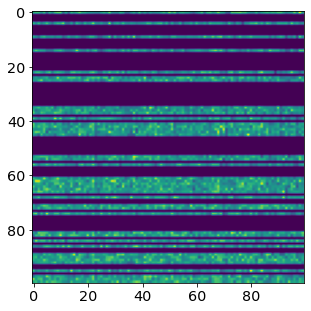

In [129]:
plt.imshow(can)

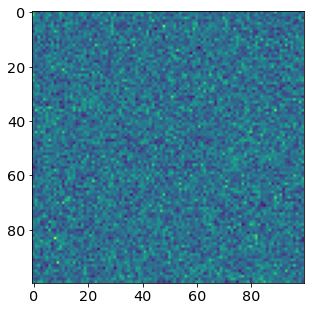

In [134]:
plt.imshow(mag)

In [131]:
score = np.multiply(can, mag)

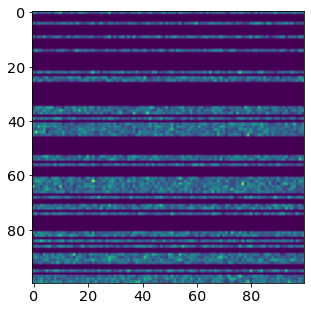

In [135]:
plt.imshow(score)

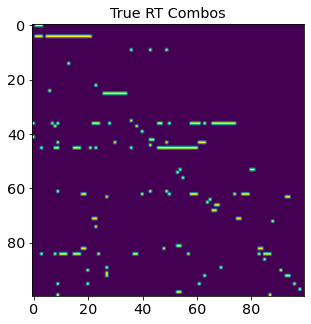

In [128]:
plt.imshow(goldIm)
plt.title('True RT Combos');

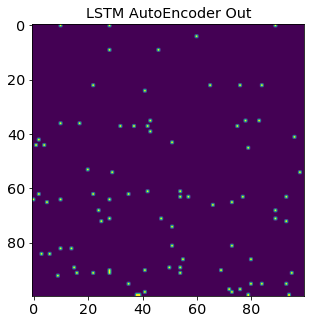

In [143]:
tscore = np.nonzero(score > score.mean() + 2.5*score.std())
tscoreIm = np.zeros(shape=goldIm.shape) 
tscoreIm[tscore] = 1
plt.imshow(tscoreIm);
plt.title('LSTM AutoEncoder Out');

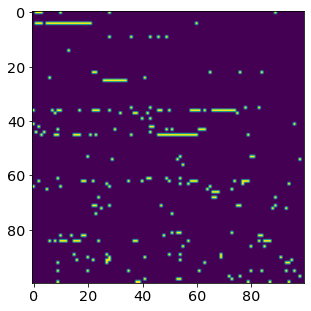

In [144]:
plt.imshow(np.abs(goldIm-tscoreIm))

In [146]:
sum(sum(np.abs(goldIm-tscoreIm)))

257.0

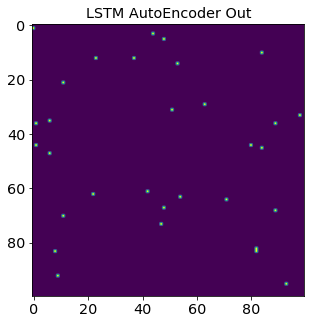

In [145]:
tmag = np.nonzero(mag > mag.mean() + 3.0*mag.std())
tmagIm = np.zeros(shape=goldIm.shape) 
tmagIm[tmag] = 1
plt.imshow(tmagIm);
plt.title('LSTM AutoEncoder Out');

# load this with the gold IM mask after copying the weights of an old auto encoder. 


In [147]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = True,  validation_data=(validation, validation),
                    callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(o.history['loss'][-1]) #the final loss 

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.2207 - val_loss: 0.1995
Epoch 2/200
1/1 [==============================] - 0s 27ms/step - loss: 0.2160 - val_loss: 0.1906
Epoch 3/200
1/1 [==============================] - 0s 26ms/step - loss: 0.2060 - val_loss: 0.1750
Epoch 4/200
1/1 [==============================] - 0s 28ms/step - loss: 0.1885 - val_loss: 0.1509
Epoch 5/200
1/1 [==============================] - 0s 27ms/step - loss: 0.1614 - val_loss: 0.1190
Epoch 6/200
1/1 [==============================] - 0s 25ms/step - loss: 0.1254 - val_loss: 0.0882
Epoch 7/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0903 - val_loss: 0.0840
Epoch 8/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0844 - val_loss: 0.0913
Epoch 9/200
1/1 [==============================] - 0s 27ms/step - loss: 0.0918 - val_loss: 0.0726
Epoch 10/200
1/1 [==============================] - 0s 25ms/step - loss: 0.0713 - val_loss: 0.0537
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 104ms/step
tf.Tensor(0.023217767, shape=(), dtype=float32)


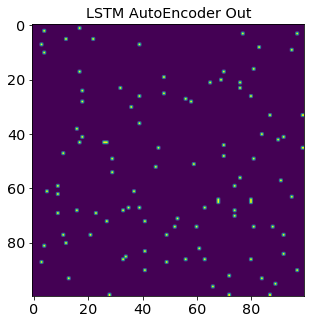

In [148]:
sparseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32, sparsity=0.98)
sparseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = sparseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = False,  validation_data=(validation, validation),
                    callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(ignore_noParent_MSE(validation, sparseParent.predict(validation)))


plt.imshow(tfMag := sparseParent.get_weights()[0])
tfmag = np.nonzero(tfMag > tfMag.mean() + 0.0*tfMag.std())
tfmagIm = np.zeros(shape=goldIm.shape) 
tfmagIm[tfmag] = 1
plt.imshow(tfmagIm);
plt.title('LSTM AutoEncoder Out');

In [149]:
# pruning_params = {
#     'pruning_schedule': PolynomialDecay(initial_sparsity=0.5,
#         final_sparsity=0.9824, begin_step=1000, end_step=2000),
#     'block_size': (2, 3),
#     'block_pooling_type': 'MAX'
# }

# model = keras.Sequential([
#     Dense(10, activation='relu', input_shape=(100,)),
#     prune_low_magnitude(layers.Dense(2, activation='tanh'), **pruning_params)
# ])

9824.0

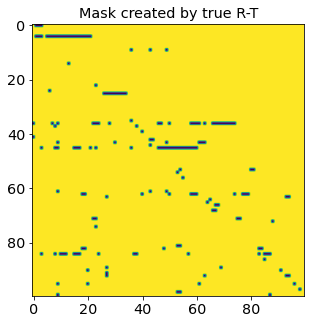

In [150]:
goldMask = 1-goldIm
goldMask = goldMask.astype(np.float32)
plt.imshow(goldMask);
plt.title("Mask created by true R-T");
sum(sum(goldMask))

9915.0

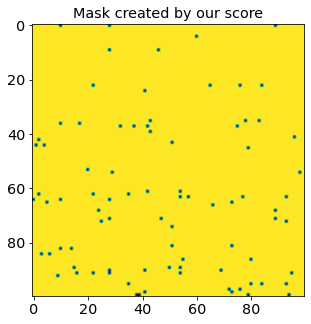

In [151]:
tscoreMask = -1.0*tscoreIm + 1.0 
tscoreMask = tscoreMask.astype(np.float32)
plt.imshow(tscoreMask);
plt.title("Mask created by our score");
sum(sum(tscoreMask))

9969.0


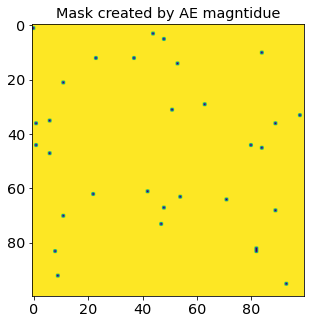

In [152]:
tmagMask = -1.0*tmagIm + 1.0 
tmagMask = tmagMask.astype(np.float32)
plt.imshow(tmagMask);
plt.title("Mask created by AE magntidue");
print(sum(sum(tmagMask)))

In [153]:
tmagAC = modelSuperParent(tmagMask, tmagMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
tmagAC.set_weights( looseParent.get_weights() )
tmagACout = tmagAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, tmagACout)
print(loss)

tf.Tensor(0.021395445, shape=(), dtype=float32)


In [154]:
scoreAC = modelSuperParent(tscoreMask, tscoreMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
scoreAC.set_weights(looseParent.get_weights())
scoreACout = scoreAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, scoreACout)
print(loss)

tf.Tensor(0.023739332, shape=(), dtype=float32)


In [155]:
goldAC = modelSuperParent(goldMask, goldMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
goldAC.set_weights(looseParent.get_weights())
goldout = goldAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, goldout)
print(loss)

tf.Tensor(0.026311439, shape=(), dtype=float32)


In [156]:
print(ignore_noParent_MSE(validation, looseParent.predict(validation)))

1/1 [==============================] - 0s 123ms/step
tf.Tensor(0.019060984, shape=(), dtype=float32)


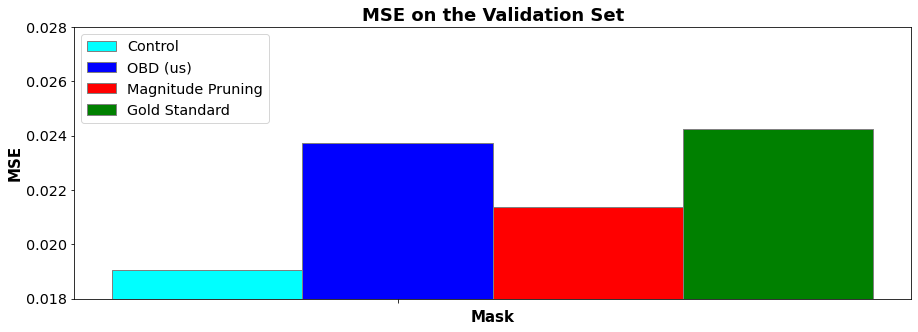

In [165]:
# import numpy as np
# import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.15
#fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = [0.019060984] #base
score = [0.023739332]
mag = [0.021395445]

ECE = [0.024257105 ]  #gold
 
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

 
# Make the plot
plt.bar(br1, IT, color ='cyan', width = barWidth,
        edgecolor ='grey', label ='Control')
plt.bar(br2, score, color ='blue', width = barWidth,
        edgecolor ='grey', label ='OBD (us)')
plt.bar(br3, mag, color ='red', width = barWidth,
        edgecolor ='grey', label ='Magnitude Pruning')
plt.bar(br4, ECE, color ='green', width = barWidth,
        edgecolor ='grey', label ='Gold Standard')
# plt.bar(br3, CSE, color ='b', width = barWidth,
#         edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Mask', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        [''])
 
plt.title("MSE on the Validation Set", fontweight='bold', fontsize = 18);
plt.legend(loc = 'upper left');
plt.ylim(0.018, 0.028)
plt.show()

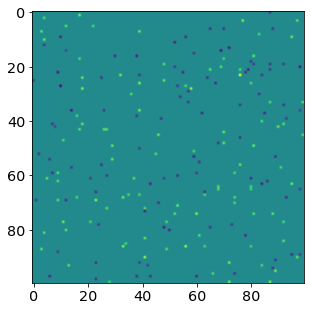

In [157]:

plt.imshow(tfMag := sparseParent.get_weights()[0])

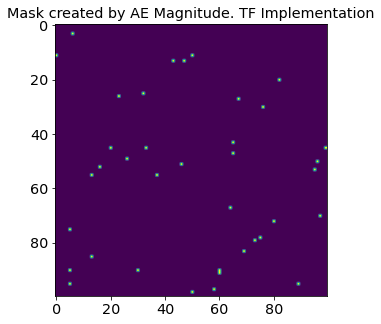

In [ ]:


tfmag = np.nonzero(np.abs(tfMag) > np.abs(tfMag)+0.01)
tfmagIm = np.zeros(shape=goldIm.shape) 
tfmagIm[tmag] = 1
plt.imshow(tfmagIm);
plt.title('Mask created by AE Magnitude. TF Implementation');

In [ ]:
tfMag

array([[-0.        , -0.        ,  0.        , ..., -0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ..., -0.        ,
         0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [-0.        ,  0.12419906,  0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         0.        ,  0.        ]], dtype=float32)

In [ ]:
#  val_loss: 0.0221

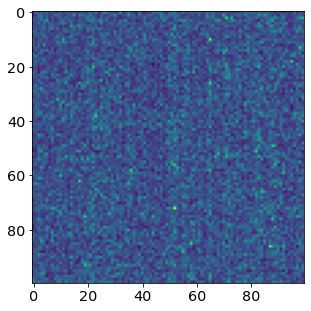

In [ ]:
plt.imshow(score)

In [ ]:
tscore

(array([ 0,  1,  2,  2,  2,  3,  8, 10, 10, 13, 14, 15, 18, 20, 20, 22, 22,
        24, 25, 26, 26, 27, 28, 28, 31, 32, 33, 38, 38, 40, 40, 42, 42, 44,
        45, 49, 51, 52, 53, 53, 53, 53, 53, 54, 54, 55, 56, 56, 57, 58, 58,
        59, 60, 62, 63, 64, 65, 66, 67, 72, 72, 74, 74, 74, 74, 75, 75, 76,
        77, 79, 80, 81, 84, 85, 86, 86, 86, 88, 89, 90, 93, 97],
       dtype=int64),
 array([32, 70, 71, 73, 99,  5, 51, 11, 65, 98, 71, 70, 95, 22, 83, 27, 59,
        71, 25, 17, 65, 68,  3, 84, 32,  9, 11, 23, 55, 50, 75, 23, 65, 78,
        98, 88, 82, 68, 12, 59, 67, 71, 83, 18, 20, 51, 52, 89,  3, 36, 65,
        92, 10, 17, 35, 89, 23, 84, 25,  7, 52, 10, 28, 40, 65, 19, 44, 88,
        58, 89, 35, 44,  3, 58, 87, 88, 92, 55, 39, 14, 19, 65],
       dtype=int64))

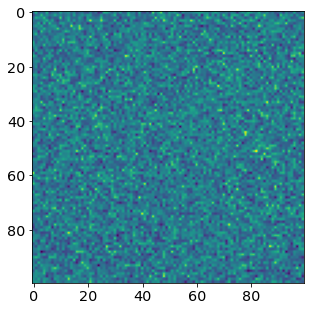

In [ ]:
plt.imshow(mag)

In [ ]:
can[19]

array([23. , 19.5, 17.9, 22.9, 16.6, 26.3, 12.4, 15.5, 15.2, 21.3, 15. ,
       13. , 22.5, 13.9, 20.5, 18.3, 11.3, 18.5, 18.7, 19.1, 20.1, 14.8,
       29.6, 26.2, 27.1, 21.9, 17.6, 12.2, 20. , 16.2, 12.1, 25.2, 16.9,
       13.9, 23.7, 19.3, 10. , 12.8, 13.3, 23.5, 32.1, 15.9, 14.7, 15.6,
        5.8, 17.1,  8. , 16.6, 17.1, 20.5, 25.6, 17.7, 22.5, 16.4, 14.4,
       25.6, 24.8, 22.6, 14. , 22.7, 11.8, 14.6, 21.9,  9.9, 17.9, 18. ,
       21. , 26.1, 23.8, 15.3, 14.3, 36.6, 19.5, 17.2, 20.2, 26.4, 29.6,
       17.3, 22. , 16.9, 13.8, 20.4, 19.9, 19.7, 23.6, 14.9, 11.9, 18. ,
       18.3, 20.9, 16.7, 15.3, 13.7, 22.8, 19.2, 13. , 15.8, 28.3, 24.7,
       18.3])

In [ ]:
goldIm[19]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
mag.max()

0.081943735

In [ ]:
mag[78]

array([0.02706154, 0.04282979, 0.03425518, 0.04917126, 0.0312528 ,
       0.02825913, 0.04126306, 0.03241092, 0.06394779, 0.04280342,
       0.05225506, 0.04618578, 0.03178521, 0.05416889, 0.04545164,
       0.04913642, 0.04508439, 0.04257184, 0.04806111, 0.03194386,
       0.03583109, 0.05528317, 0.05768529, 0.04382673, 0.04510432,
       0.02755378, 0.03684839, 0.03637389, 0.02637753, 0.04171947,
       0.04204965, 0.04951122, 0.02916988, 0.04468329, 0.03725954,
       0.03456458, 0.04339793, 0.0417766 , 0.04620445, 0.02662002,
       0.02573772, 0.02811158, 0.03731451, 0.03466142, 0.04022574,
       0.03947539, 0.02733521, 0.01822177, 0.02850093, 0.05035462,
       0.04402521, 0.04499938, 0.03706072, 0.0414778 , 0.05277729,
       0.03500762, 0.0360116 , 0.04548286, 0.05254378, 0.04940482,
       0.03388819, 0.04318474, 0.02996325, 0.03753154, 0.04852914,
       0.04720645, 0.03852938, 0.03653208, 0.05247019, 0.02332587,
       0.04211653, 0.0474331 , 0.07331613, 0.04274044, 0.04646

In [ ]:
can[4]

array([16.33333333, 11.33333333,  5.66666667,  7.33333333, 21.        ,
       39.33333333, 12.        , 18.66666667, 13.33333333, 14.33333333,
       13.        , 29.        , 16.66666667, 12.66666667, 15.66666667,
       28.        , 23.66666667, 45.66666667, 15.66666667, 18.        ,
       16.33333333, 17.33333333, 13.        , 20.        , 12.        ,
       18.33333333, 20.        , 18.        , 27.66666667, 13.66666667,
        8.66666667, 14.33333333, 20.66666667, 34.66666667, 19.33333333,
       13.66666667, 14.        , 22.        , 28.66666667, 11.66666667,
        5.33333333,  8.66666667, 23.        , 29.33333333, 14.        ,
       15.66666667, 33.33333333, 18.33333333, 10.        , 21.        ,
       17.66666667, 16.66666667, 26.66666667, 26.        , 34.33333333,
       10.33333333, 21.        , 14.        , 18.        ,  5.66666667,
       12.        , 26.66666667, 11.66666667, 12.        , 17.        ,
       14.33333333, 28.33333333, 15.33333333, 13.33333333, 10.33

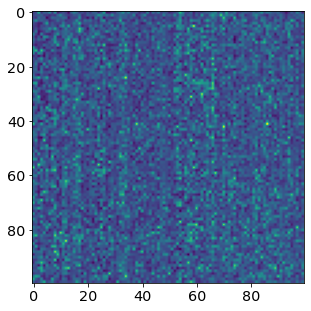

In [ ]:
plt.imshow(can)

In [ ]:
(np.cov(score, goldIm))


array([[ 2.80772409e-01, -1.29219191e-02, -5.49620703e-03, ...,
         1.66804923e-03,  4.36776243e-03, -2.50142940e-03],
       [-1.29219191e-02,  2.18575482e-01,  9.01092191e-03, ...,
         2.08848885e-03, -4.06803179e-03, -3.72603467e-03],
       [-5.49620703e-03,  9.01092191e-03,  1.69630042e-01, ...,
        -3.29844492e-03,  3.02717165e-03,  2.30775956e-03],
       ...,
       [ 1.66804923e-03,  2.08848885e-03, -3.29844492e-03, ...,
         1.00000000e-02, -2.02020202e-04, -2.02020202e-04],
       [ 4.36776243e-03, -4.06803179e-03,  3.02717165e-03, ...,
        -2.02020202e-04,  1.97979798e-02, -4.04040404e-04],
       [-2.50142940e-03, -3.72603467e-03,  2.30775956e-03, ...,
        -2.02020202e-04, -4.04040404e-04,  1.97979798e-02]])

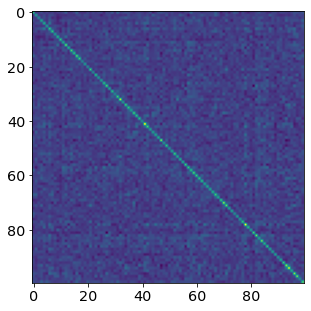

In [ ]:
plt.imshow(np.cov(goldIm, score)[100:, 100:])
#[100:, 100:]

In [ ]:
u = np.vstack([goldIm.flatten(), score.flatten()])
u.shape

(2, 10000)

In [ ]:
np.cov(u)

array([[0.01729197, 0.00038564],
       [0.00038564, 0.26836662]])

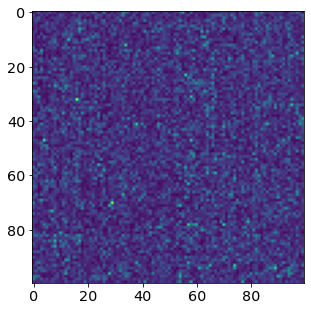

In [ ]:
plt.imshow(score);

In [ ]:
np.argmin(score)

2654

In [ ]:
score[score > score.mean() + score.var()]

array([1.0600858 , 1.28842928, 1.56563523, ..., 1.21438978, 1.65346416,
       0.95672795])

In [ ]:
# pdf, bins = np.histogram(can, np.arange(NUM_PARENTS*NUM_TARGETS))
# pdf

In [ ]:
mag.shape

(100, 100)

# Magnitudes After Training

In [ ]:
NUM_PARENTS*NUM_TARGETS

10000

In [ ]:
#np.unravel_index(NUM_PARENTS*NUM_TARGETS, shape = (NUM_PARENTS, NUM_TARGETS))

In [ ]:
pdf, bins = np.histogram(can, bins=NUM_PARENTS*NUM_TARGETS)

In [ ]:
len(bins)

10001

In [ ]:
pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))

In [ ]:
bins

array([   0,    1,    2, ..., 9997, 9998, 9999])

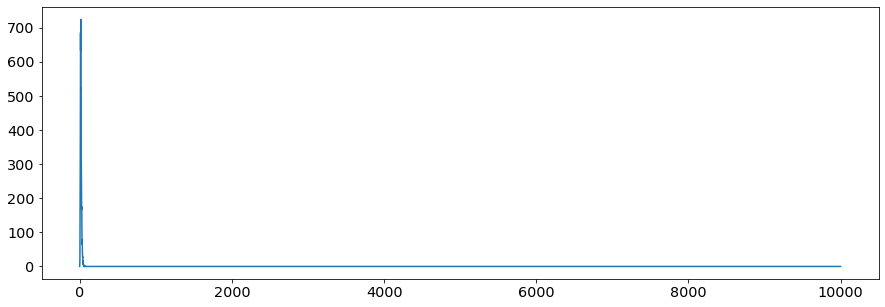

In [ ]:
plt.plot(pdf)

In [ ]:
# plt.hist(pdf, bins)

In [ ]:
#TODO: CHECK ME
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))
    
    pdf2d = np.zeros(shape = (NUM_PARENTS,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins), bins[-1])
    

    importance = np.multiply(pdf2d, mag)
    return importance

In [ ]:
top = get_top_reg_targets(can, mag)

9999 (99, 99) 9999 10000 9999


In [ ]:
top.shape

(100, 100)

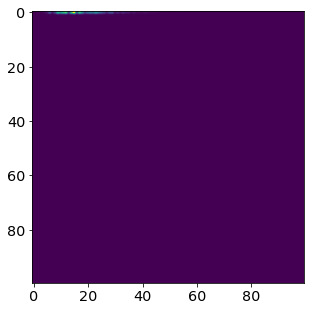

In [ ]:
plt.imshow(top)

#TODO: try factorial data, ordinary Auto encoder, treshold, tensorflow pruning, check average epoch of lazy kernel

#TODO: Actually measure MSE 

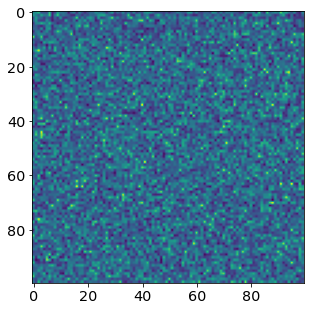

In [ ]:
plt.imshow(mag)

In [ ]:
# lm = pd.DataFrame(top)
# lm.to_csv("top_r_t_HepG2.csv")

In [ ]:
# topdf = pd.read_csv('top_r_t_HepG2.csv')
# topdf.head(5)


In [ ]:
# top = np.array(topdf)
# plt.imshow(top)

In [ ]:
# top = top[:,1:]
# plt.imshow(top)

In [ ]:
# np.max(top)

In [ ]:
np.array(non_zero).shape

(2, 176)

In [ ]:
top[non_zero].mean()

0.005536854965612292

In [ ]:
mag[non_zero].mean()


0.040724885

In [ ]:
mag.mean()

0.04035949

In [ ]:
top.mean()

0.03671660170769319

In [ ]:
no_connect = np.where(goldIm == 0)
no_connect = np.array(no_connect)
no_connect.shape

(2, 9824)

In [ ]:
top[no_connect].mean()

0.036440031214373836

In [ ]:
mag[no_connect].mean()

0.040359307

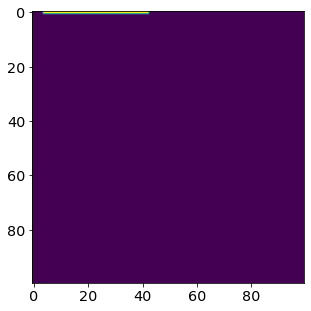

In [ ]:
mag01 = MinMaxScaler().fit_transform(mag.reshape((-1,1)))
tff = mag01.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std
magt = np.where(top > mu + 2*std, 1, 0)
magt.dtype = 'int'
plt.imshow(magt.reshape(100,100))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm.flatten(), magt.flatten(), average='samples')

0.4980150651465798

In [ ]:
top01 = MinMaxScaler().fit_transform(top.reshape((-1,1)))

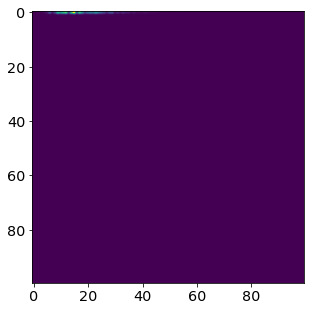

In [ ]:
plt.imshow(top01.reshape(100,100))

In [ ]:
tff = top01.flatten()
std = np.std(tff)

mu = np.mean(tff)
print(mu, std)
yout = np.where(top01.flatten() > mu + 4*std, 1, 0)
yout.dtype = 'int'

0.0010382505509709966 0.022471539729100008


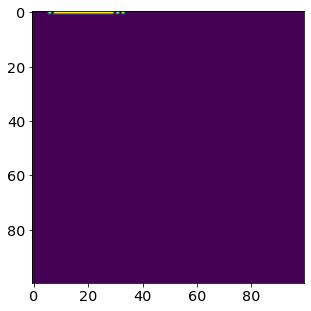

In [ ]:
plt.imshow(yout.reshape(100,100))

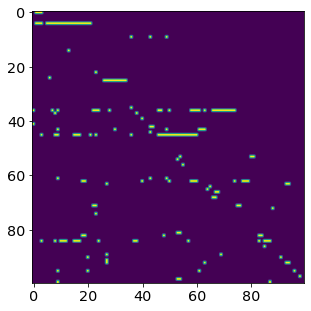

In [ ]:
plt.imshow(goldIm)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm.flatten(), (yout).flatten(), average='samples')

0.4987276058631922

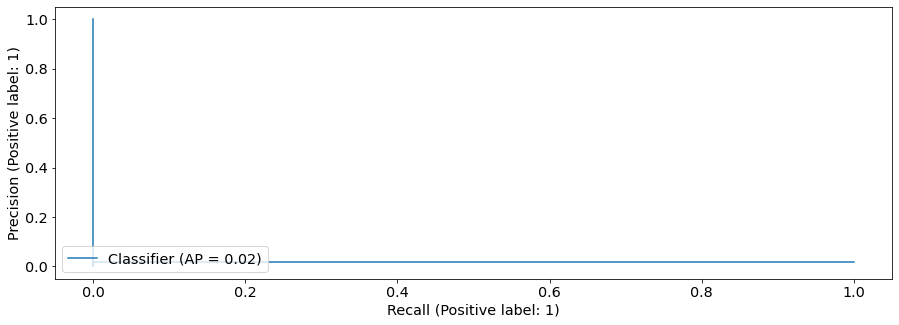

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(goldIm.flatten(), yout.flatten());

In [ ]:
tff = top.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std
yout = np.where(top > mu + 3*std, 1, 0)
yout.dtype = 'int'

In [ ]:
roc_auc_score(goldIm.flatten(), yout.flatten(), average='samples')

0.49867671009771986

In [ ]:
magX = StandardScaler().fit_transform(top.reshape((-1,1)))
magX = MinMaxScaler().fit_transform(magX.reshape((-1,1)))
you2 = np.where(magX > mu + 3*std, 1, 0)

In [ ]:
roc_auc_score(goldIm.flatten(), you2.flatten(), average='samples')

0.5

# Draw old graphs; probably trash

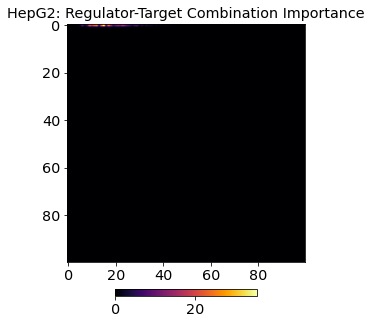

In [ ]:
u = plt.imshow(top, cmap = 'inferno', vmin = 0, vmax = np.max(top));
plt.colorbar(u ,fraction=0.026, pad=0.1, orientation='horizontal');
plt.title("HepG2: Regulator-Target Combination Importance");

In [ ]:
topID = np.array(np.unravel_index(np.argsort(top, axis=None), top.shape))
topID = np.flip(topID, axis=1)
topID[0] = parent_idx[topID[0]]
topID = topID.T
topID

array([[ 0, 15],
       [ 0, 12],
       [ 0, 17],
       ...,
       [66, 64],
       [66, 63],
       [ 0,  0]], dtype=int64)

In [ ]:
topR_T = pd.DataFrame(topID)
topR_T.to_csv("DREAM4_Top_reg_target_decendingOrder_firstColIsRegulator.csv")

In [ ]:
best = np.zeros(NUM_PARENTS)
for i in range(NUM_PARENTS):
    best[i] = np.sum(top[i])
best

array([367.16601708,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

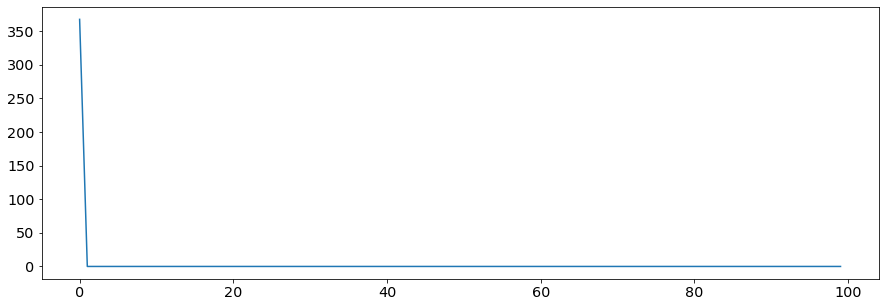

In [ ]:
x = np.arange(0,NUM_PARENTS, dtype=int)
plt.plot(x, best); 

In [ ]:
idx = np.flip(np.argsort(best))
idx

array([ 0, 36, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 98, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 25, 24, 23, 22,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 48, 99,
       50, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 76, 74, 51, 73, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 49],
      dtype=int64)

In [ ]:
parent_idx[idx] 

array([ 0, 36, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 98, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 25, 24, 23, 22,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 48, 99,
       50, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 76, 74, 51, 73, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 49])

In [ ]:
np.unique(can).size

167

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

NameError: name 'data_path_petal' is not defined

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

In [ ]:
experiment1.shape
testCandidate.shape

In [ ]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(beanIntensities, beanIntensities,validation_data=(experiment1, experiment1),  epochs=100,  verbose=1)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

In [ ]:
rgm = superParent
time_steps = 6
num_kinase_regulators = NUM_TARGETS
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, NUM_TARGETS, NUM_TARGETS)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(32, activation = 'swish', use_bias=True, kernel_regularizer='l1_l2')(denseP.layers[-1].output)
l = Dense(1, activation = 'linear', use_bias = True)(l)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=500, verbose = 1)

In [ ]:
testCandidate.shape

In [ ]:
denseP(experiment1) #experiment1 is part of the training set.

In [ ]:
petal_train

In [ ]:
print(denseP(testCandidate)) #model output

In [ ]:
petal_test #true label

In [ ]:
petal_train

In [ ]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

# Junk

# Load the test set and the synthetic dataset:


In [ ]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [ ]:
def read_files(data_path):

    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [ ]:
beanIntensities, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = beanIntensities

In [ ]:
matrix.shape

In [ ]:
replicates.shape

In [ ]:
plt.imshow(matrix)

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parentIndex]

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

In [ ]:
dd

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

In [ ]:
top_pr.shape

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
type(enc_dec_Synthetic)

In [ ]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

In [ ]:
newConnections = superParent - regulator_gene_matrix

In [ ]:
plt.imshow(newConnections)

In [ ]:
# nC = []
# for i in range(len(newConnections[0])):
#     for j in range(len(newConnections[1])):
#         if newConnections[i][j] > 0:
#             nC.append([i,j])
# nC = np.array(nC)
# nC = pd.DataFrame(nC)
# nC.to_csv("new_connections_in_superParents.csv")

In [ ]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [ ]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
syntheticDataTrain = beanIntensities[1:]

In [ ]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

In [ ]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

In [ ]:
w = enc_dec_Synthetic.get_weights()

In [ ]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [ ]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [ ]:
testCandidate = test.numpy().astype(np.float)

In [ ]:
testCandidate.dtype

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
testCandidate[0].shape

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

In [ ]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [ ]:
print(outSyn.shape)

In [ ]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

In [ ]:
(outSyn-testCandidate).shape

In [ ]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
# test = loadTestSet(data_path_testSet)
# testCandidate = test.astype(np.float)


In [ ]:
enc_dec_Synthetic = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS) #we can just change the time steps to something higher

In [ ]:
enc_dec_Synthetic.summary()

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [ ]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [ ]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [ ]:
interpolated_genes.shape

In [ ]:
pd.DataFrame(interpolated_genes[2]).head(5)

In [ ]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,NUM_TARGETS)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,NUM_TARGETS)))
inter = np.vstack(inter)

In [ ]:
inter.shape

In [ ]:
beanIntensities[1:].shape

In [ ]:
enc_dec_inter = model(regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
enc_dec_inter.fit(inter, inter,epochs=1000);

In [ ]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

In [ ]:
interpolationLoss #used to be 3.84 on broke ignore

In [ ]:
outInter.shape

In [ ]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

In [ ]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,NUM_TARGETS)), cmap = "hot", vmin=0,vmax=1.0 );

In [ ]:
u = pd.DataFrame(outSyn[0])
u.head(10)

In [ ]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,NUM_TARGETS)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [ ]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,NUM_TARGETS)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,NUM_TARGETS)).T)[parent_idx]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [ ]:
pd.DataFrame(oSyn).head(24)

In [ ]:
pd.DataFrame(exp1_col).head(24)


In [ ]:
pd.DataFrame(ddff).head(24)


In [ ]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", beanIntensities[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1